# TITLE

### Intro

This project investigates what player characteristics and behaviors are most predictive of subscribing to a game-related newsletter. The specific research question is: “How does a player's total time played, and average time of day of their play session predict their subscription status?”. Both the data sets (players_data, and sessions_data) are utilized to predict the subscription status using the 2 chosen factors. This is because merging the data sets allows us to include information about both the background of each player and sessions played by each player. From this information, we would then read, wrangle, visualize, and use KNN classification to find the closest distance compared to the targeted data point. Lastly, a confusion matrix will be created to evaluate the accuracy of the created model. 

### Data Description
The combined dataset contains many variables, some from the players data and some from the sessions data. Below, is an explanation for each variable from both datasets.
#### Variables from players.csv
- experience: the players' self-reported experience levels with minecraft ranging from "Beginner" being the least experienced to "Pro" being the most experienced
- subscribe: whether or not the player chose to subscribe to a game related newsletter. Can be TRUE or FALSE
- played_hours: numerical variable, the number of hours the player has spent playing on the server
- name: Not the real names of the participants, rather this variable contains the screen name the players chose from a random list during registration. Variable is a string of characters, not numeric
- gender: gender of the participants, who can select between Male, Female, Two-spirit, Agender, Non-binary, and Prefer not to say
#### Variables from sessions.csv
- start_time: a string of characters giving the date and time of the start of a session
- end_time: a string of characters giving the date and time of the end of a session
- original_start_time: a numerical value that coresponds to the start time of a session, not very useful when we already have start time in a nicer format 
- original_end_time: a numerical value that coresponds to the end time of a session, not very useful when we already have the end time in a nicer format
#### Variables from both datasets
- hashedEmail: a string of characters coresponding to a player's email adress used in registration. This is how we identify individual players, and how we combine the two datasets since it's the only shared variable

### Methods and Results

The most appropriate method for investigating whether or not time of day of sessions, total time played, and age are predictive of newsletter subscription would be knn classification. Our question is pretty clearly a classification question, so it makes sense to use the knn classificaiton method learned in class.But, before we can start the model we have to deal with the fact that the dataset is tiny and mostly full of users who subscribed. To remedy this we'll create "new" datapoints that didnt subscribe by taking samples of 10 users who didn't subscribe, averaging the values of their predictor values, and treating that as a new datapoint. This will be repeated 89 times until there are equal subscribed and non-subscribed users. The knn model will have to scale and center all of the variables, but doing so requires the assumption that all of the predictor values are equally important in predicting subscription status, which likely isn't true. In order to train the knn model, we will have to split the data (after it has been wrangled) into training and testing, but the exact ratio of that split is something that can be decided later. As for the wrangling itself, we'll need to at least do what we mentioned in the question section, and it may be helpful to select only the columns in the combined dataset that are relevant to our question. Lastly, we will use cross-validation in the training of the model to determine the ideal number of neighbours. 

In [1]:
#loading in data and doing some wrangling
library(tidyverse)
library(tidymodels)
library(themis) 


if (!dir.exists("data")) {
    dir.create("data")
}

download.file("https://raw.githubusercontent.com/nt8669/DSCI-100-007-24-Project/refs/heads/main/data/players.csv", "data/players.csv")
download.file("https://raw.githubusercontent.com/nt8669/DSCI-100-007-24-Project/refs/heads/main/data/sessions.csv", "data/sessions.csv")

players_data <- read_csv("data/players.csv")
sessions_data <- read_csv("data/sessions.csv")

sessions_data <- sessions_data |>
    mutate(start_time = as.POSIXlt(start_time, format = "%d/%m/%Y %H:%M")) |>
    mutate(end_time = as.POSIXlt(end_time, format = "%d/%m/%Y %H:%M"))
players_data <- players_data |>
    mutate(experience = as.factor(experience)) |>
    mutate(gender = as.factor(gender))

combined_data <- full_join(players_data, sessions_data, by = "hashedEmail") |>
    mutate(has_played = !is.na(start_time)) |>
    select(-original_start_time, -original_end_time)
head(combined_data)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

experience,subscribe,hashedEmail,played_hours,name,gender,Age,start_time,end_time,has_played
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dttm>,<dttm>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-08-08 00:21:00,2024-08-08 01:35:00,TRUE
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-09-09 22:30:00,2024-09-09 22:37:00,TRUE
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-08-08 02:41:00,2024-08-08 03:25:00,TRUE
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-09-10 15:07:00,2024-09-10 15:29:00,TRUE
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-05-05 22:21:00,2024-05-05 23:17:00,TRUE
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-04-06 22:24:00,2024-04-06 23:33:00,TRUE


In [2]:
#finding the middle time of each play session
combined_data <- mutate(combined_data, mid_time = start_time + (end_time - start_time) / 2, 
                        mid_time_dateless = format(mid_time, "%H:%M:%S") |>
                        as.POSIXct(format = "%H:%M:%S")) |>
    filter(!is.na(Age))
#midtime datelss just sets the date to today so we can look at only time
# This one was really unintuitive and weird (why can't you add POSIXt objects??)
head(combined_data)

experience,subscribe,hashedEmail,played_hours,name,gender,Age,start_time,end_time,has_played,mid_time,mid_time_dateless
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dttm>,<dttm>,<lgl>,<dttm>,<dttm>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-08-08 00:21:00,2024-08-08 01:35:00,TRUE,2024-08-08 00:58:00,2025-04-05 00:58:00
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-09-09 22:30:00,2024-09-09 22:37:00,TRUE,2024-09-09 22:33:30,2025-04-05 22:33:30
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-08-08 02:41:00,2024-08-08 03:25:00,TRUE,2024-08-08 03:03:00,2025-04-05 03:03:00
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-09-10 15:07:00,2024-09-10 15:29:00,TRUE,2024-09-10 15:18:00,2025-04-05 15:18:00
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-05-05 22:21:00,2024-05-05 23:17:00,TRUE,2024-05-05 22:49:00,2025-04-05 22:49:00
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-04-06 22:24:00,2024-04-06 23:33:00,TRUE,2024-04-06 22:58:30,2025-04-05 22:58:30


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


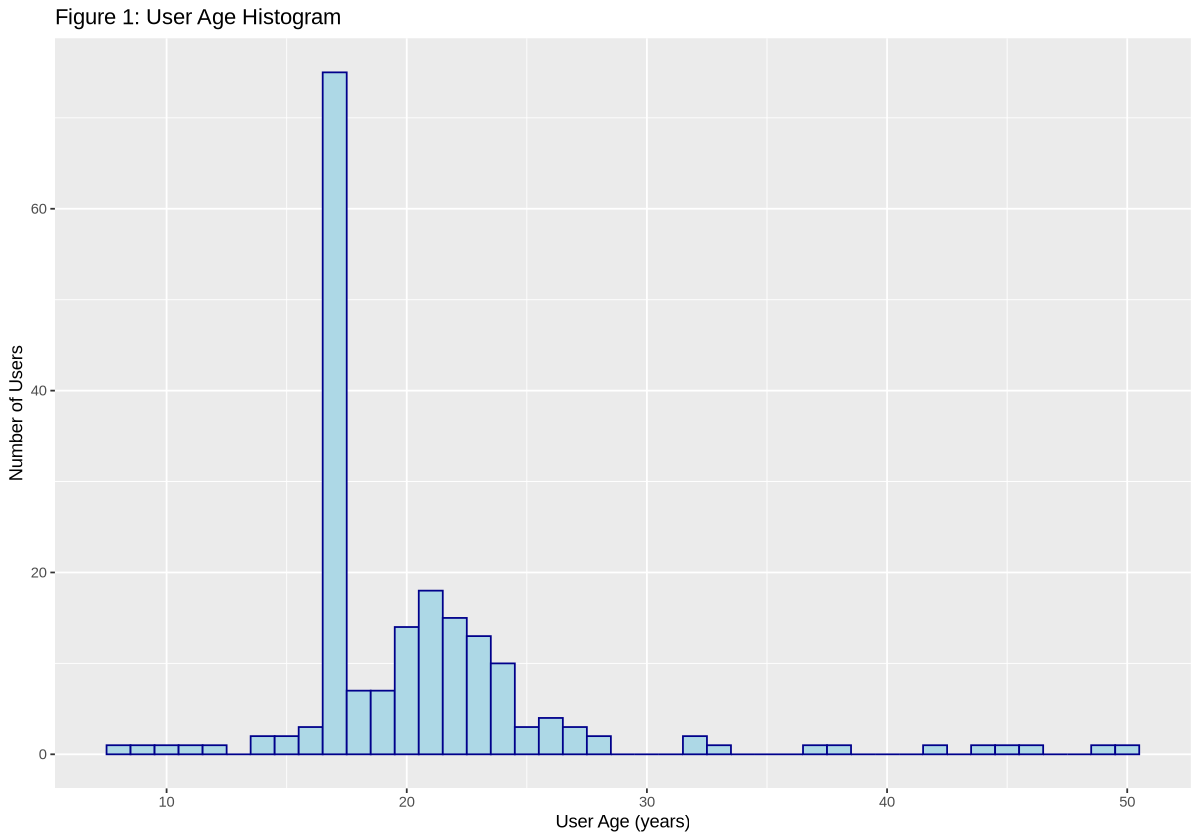

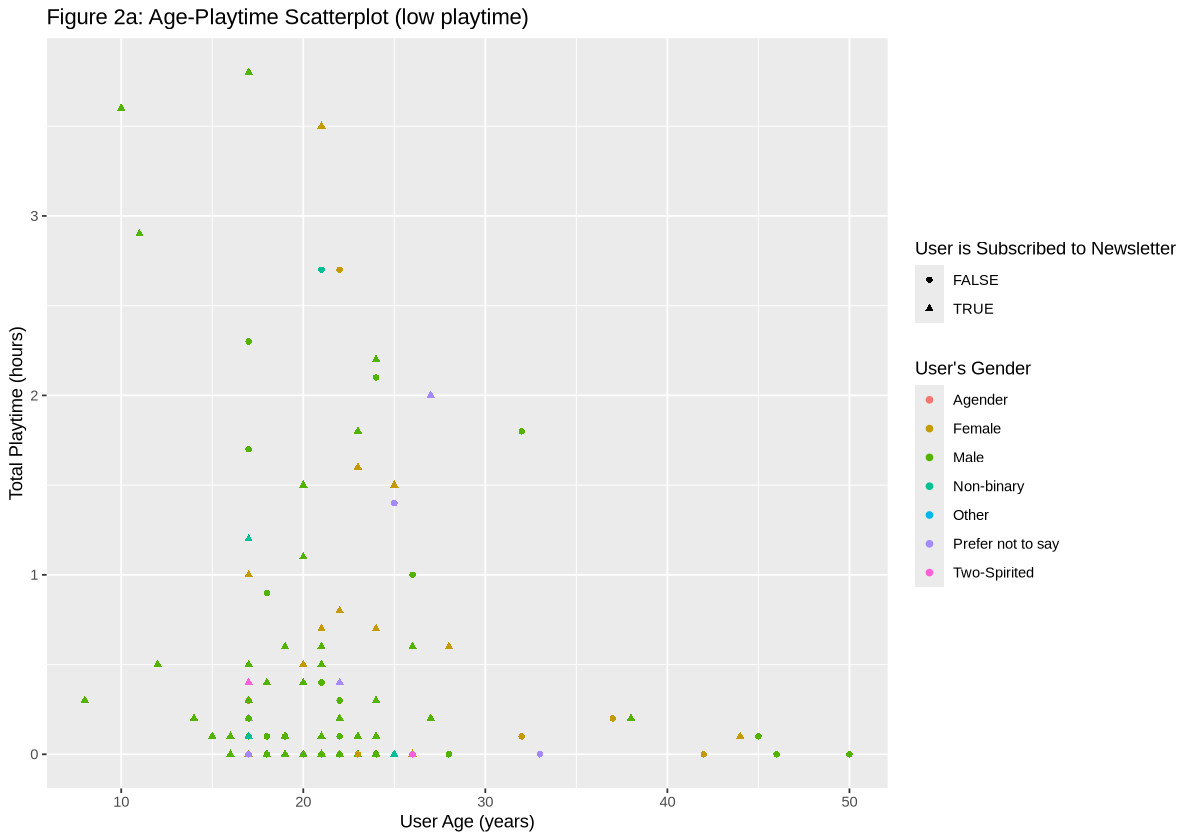

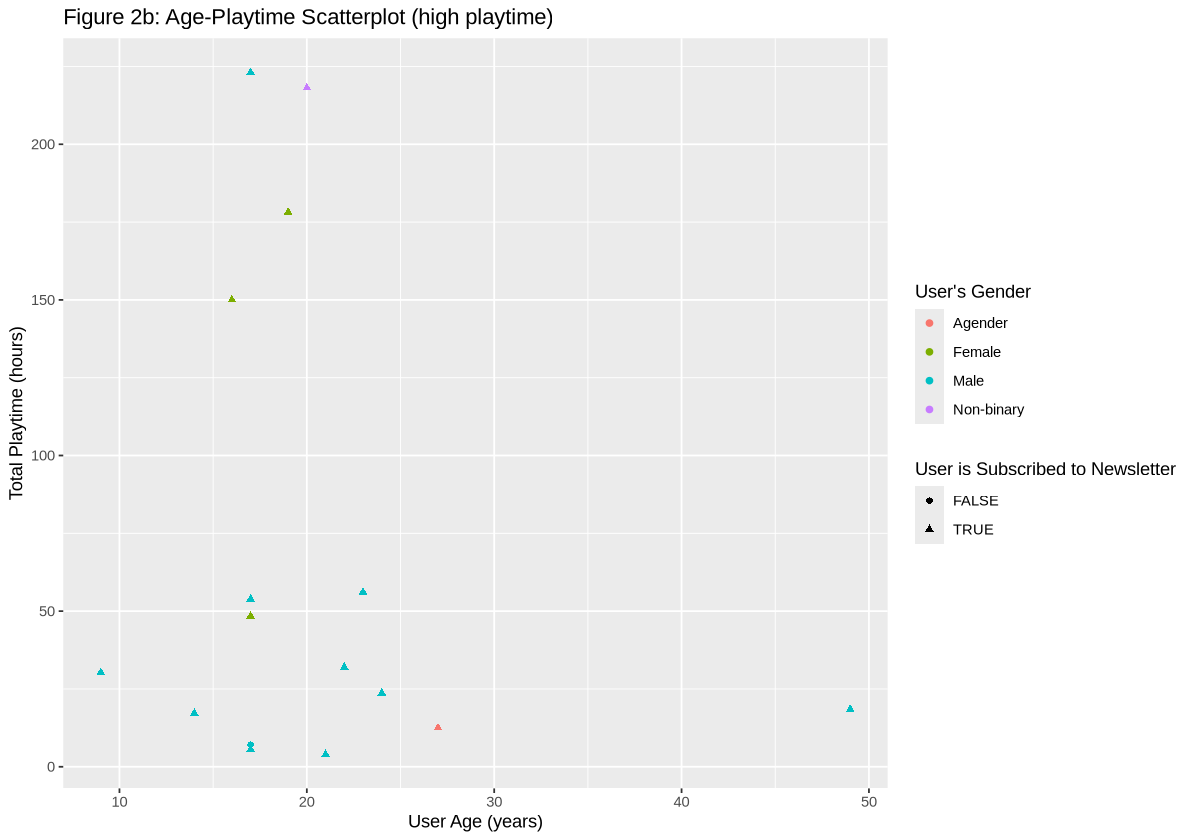

Warning message:
“Removed 73 rows containing non-finite outside the scale range (`stat_bin()`).”


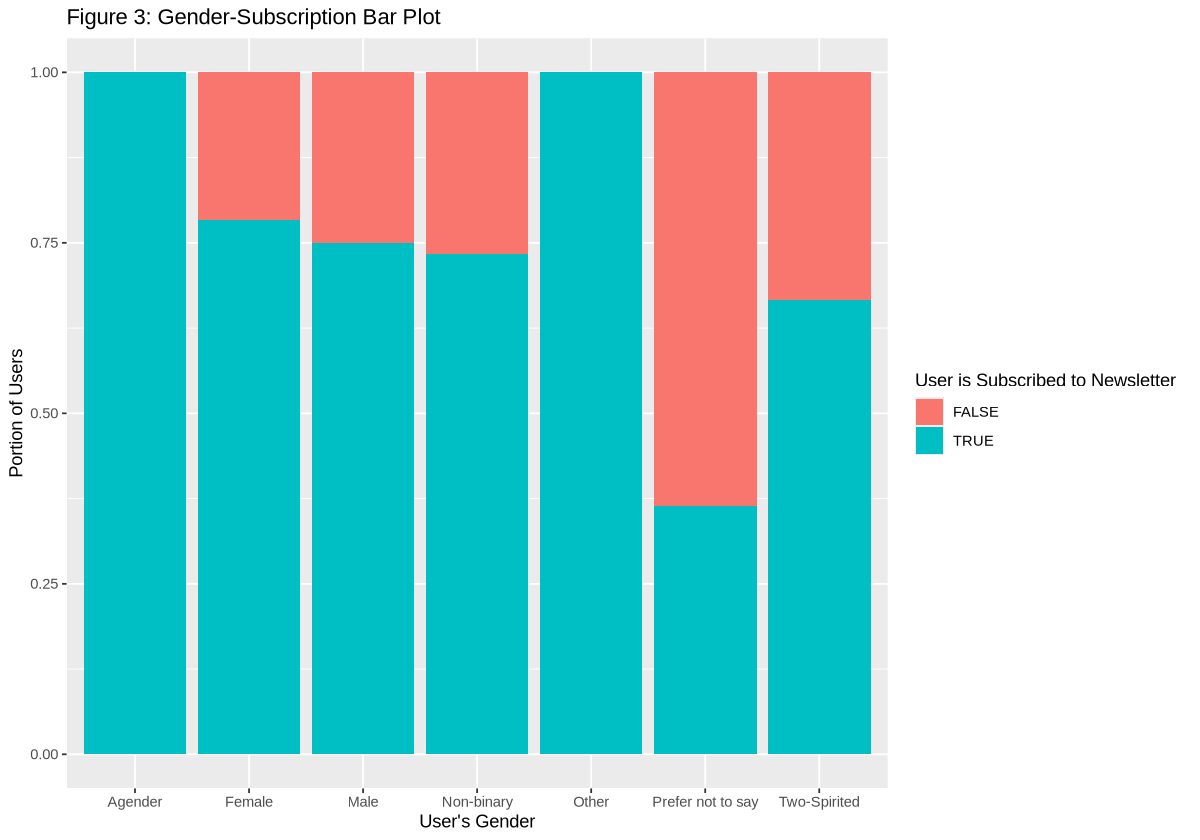

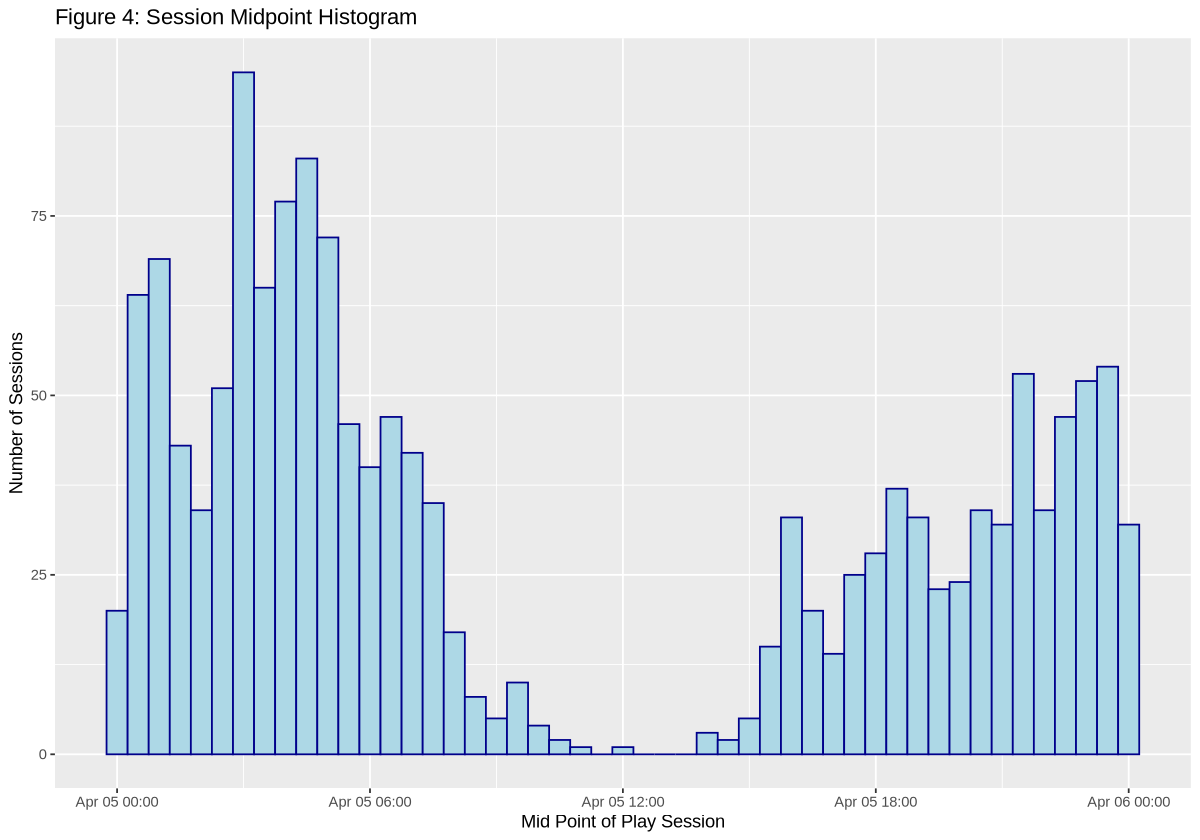

In [3]:
#Plots
options(repr.plot.width = 10)

age_hist <- players_data |>
    ggplot(aes(x = Age)) +
    geom_histogram(color = "dark blue", fill = "light blue", binwidth = 1) +
    labs(x = "User Age (years)", y = "Number of Users", title = "Figure 1: User Age Histogram")

age_v_playtime_low <- players_data |> 
    filter(played_hours < 4) |>
    ggplot(aes(x = Age, y = played_hours)) +
    geom_point(aes(shape = subscribe, color = gender)) +
    labs(y = "Total Playtime (hours)", x = "User Age (years)", title = "Figure 2a: Age-Playtime Scatterplot (low playtime)",
         color = "User's Gender", shape = "User is Subscribed to Newsletter")

age_v_playtime_high <- players_data |> 
    filter(played_hours >= 4) |>
    ggplot(aes(x = Age, y = played_hours)) +
    geom_point(aes(shape = subscribe, color = gender)) +
    labs(y = "Total Playtime (hours)", x = "User Age (years)", title = "Figure 2b: Age-Playtime Scatterplot (high playtime)",
         color = "User's Gender", shape = "User is Subscribed to Newsletter")

players_bar <- players_data |>
    ggplot(aes(x = gender, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "User's Gender", y = "Portion of Users", 
         fill = "User is Subscribed to Newsletter",
         title = "Figure 3: Gender-Subscription Bar Plot")

mid_time_hist <- combined_data |>
    ggplot(aes(x = mid_time_dateless)) +
    geom_histogram(color = "dark blue", fill = "light blue", binwidth = 1800) +
    labs(x = "Mid Point of Play Session", y = "Number of Sessions", title = "Figure 4: Session Midpoint Histogram")

age_hist
age_v_playtime_low
age_v_playtime_high
players_bar
mid_time_hist

In [4]:
model_data <- combined_data |>
    filter(has_played == TRUE) |>
    group_by(hashedEmail) |>
    summarize(mean_mid_time = mean(mid_time_dateless)) |>
    full_join(players_data, by = "hashedEmail") |>
    mutate(mean_mid_time = as.POSIXct(mean_mid_time),
          subscribe = as.factor(subscribe)) |>
    filter(!is.na(mean_mid_time))
head(model_data)

hashedEmail,mean_mid_time,experience,subscribe,played_hours,name,gender,Age
<chr>,<dttm>,<fct>,<fct>,<dbl>,<chr>,<fct>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2025-04-05 12:13:30,Regular,TRUE,1.5,Isaac,Male,20
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,2025-04-05 04:43:00,Pro,FALSE,0.4,Lyra,Male,21
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,2025-04-05 21:06:30,Beginner,TRUE,0.1,Osiris,Male,17
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,2025-04-05 10:50:32,Regular,TRUE,5.6,Winslow,Male,17
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,2025-04-05 20:21:30,Pro,TRUE,1.0,Knox,Male,17
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,2025-04-05 08:01:00,Veteran,FALSE,0.1,Callum,Male,19


In [11]:
# Bootstrap to balance classes
set.seed(123)
not_subscribed <- model_data |> filter(subscribe == FALSE)
subscribed <- model_data |> filter(subscribe == TRUE)

upsampled_false <- not_subscribed |> 
  rep_sample_n(size = 10, replace = TRUE, reps = 89)

summarized_false <- upsampled_false |> 
    group_by(replicate) |> 
    summarise(played_hours = mean(played_hours, na.rm = TRUE),
              mean_mid_time = mean(as.numeric(mean_mid_time), na.rm = TRUE),
              subscribe = factor(FALSE, levels = c(FALSE, TRUE))) |> 
    mutate(mean_mid_time = as.POSIXct(mean_mid_time))

balanced_model_data <- bind_rows(subscribed, summarized_false)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8242754,3,0.03795711,Preprocessor1_Model01
2,accuracy,binary,0.8242754,3,0.03795711,Preprocessor1_Model02
3,accuracy,binary,0.8309179,3,0.01226827,Preprocessor1_Model03
4,accuracy,binary,0.8309179,3,0.01226827,Preprocessor1_Model04
5,accuracy,binary,0.8022343,3,0.02744597,Preprocessor1_Model05
6,accuracy,binary,0.8022343,3,0.02744597,Preprocessor1_Model06
7,accuracy,binary,0.7820048,3,0.01641579,Preprocessor1_Model07
8,accuracy,binary,0.7820048,3,0.01641579,Preprocessor1_Model08
9,accuracy,binary,0.8031401,3,0.01147343,Preprocessor1_Model09


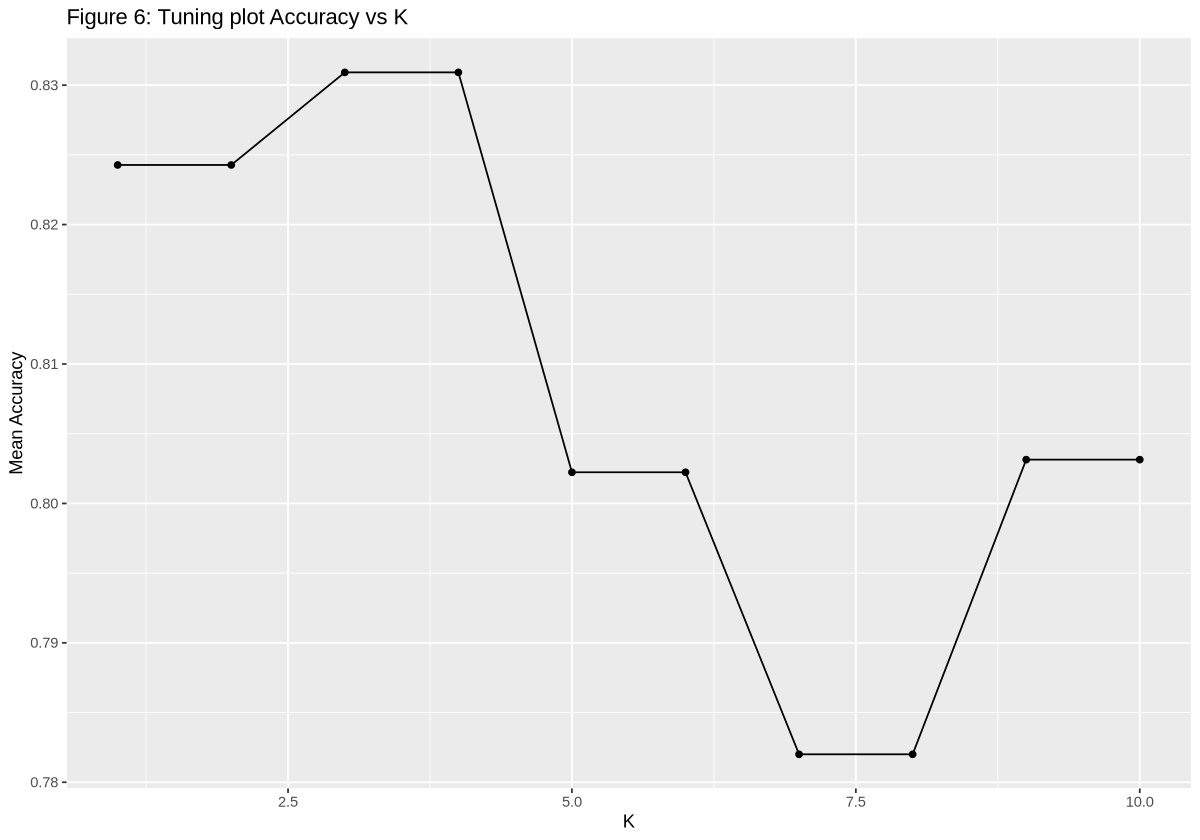

In [13]:
set.seed(10844538)


combined_split <- initial_split(balanced_model_data, 0.80, strata = subscribe)
combined_training <- training(combined_split)
combined_testing <- testing(combined_split)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))


# Recipe
combined_recipe <- recipe(subscribe ~ played_hours + mean_mid_time, data = combined_training) |>
  step_time(mean_mid_time) |>
  step_mutate(mean_mid_time = (mean_mid_time_hour * 3600 +
                                mean_mid_time_minute * 60 +
                                mean_mid_time_second)) |>
  step_normalize(all_predictors())

tuning_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

combined_vfold <- vfold_cv(combined_training, v = 3, strata = subscribe)

# #only care abt accuracy here
tuning_accuracy <- workflow() |>
    add_model(tuning_model) |>
    add_recipe(combined_recipe) |>
    tune_grid(resamples = combined_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

tuning_accuracy

k_plot <- tuning_accuracy |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "Mean Accuracy", title = "Figure 6: Tuning plot Accuracy vs K")

k_plot

Set K = 3 because of the plot.

In [9]:
final_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

combined_fit <- workflow() |>
    add_recipe(combined_recipe) |>
    add_model(final_model) |>
    fit(combined_training)

combined_test_preds <- predict(combined_fit, combined_testing) |>
    bind_cols(combined_testing)

test_accuracy <- combined_test_preds |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

test_confmat <- combined_test_preds |>
    conf_mat(truth = subscribe, estimate = .pred_class)

test_confmat
test_accuracy

          Truth
Prediction FALSE TRUE
     FALSE    18    5
     TRUE      0   13

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8611111


###  Discussion

We decided to take a bootstrap sample within the dataset and found that the optimal K-value is 3. There are 18 true negative values, 5 false negative values, 0 false positive values and 13 true positive values, out of a total of 36 observations from the confusion matrix. From here, we can conclude that: 

Accuracy = (18+13)/36 x 100% = 86.1% 

This model has a 86.1% accuracy, which is decent. Due to the small dataset we have, we are limited in the number of predictors we can use in modelling to avoid overfitting. It is close to what we expect because not only was the K-value large and had a lower accuracy level (73.7%) before taking a bootstrap sample, with all observations are positive and there are no negative predictions - indicating that the data is biased. Besides, a small dataset can affect the K value we obtain from cross-validation, for example getting a large K value in a small dataset. As we only used accuracy as the sole metric for evaluating a classifier, there is a potential of not knowing the type of mistakes a model makes. With this finding on subscription status, developers can adjust in-game newsletter sign-up opportunities based on when players are the most active.

Future questions can use other characteristics, such as age and gender, to predict the subscription level of players, given that we have a larger dataset for a more comprehensive prediction. Additionally, precision and recall can be used as evaluation metrics to improve the effectiveness of the model. 
